In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from collections import Counter


In [ ]:
benign_df = pd.read_csv('1.benign.csv')
g_c_df = pd.read_csv('1.gafgyt.combo.csv')
g_j_df = pd.read_csv('1.gafgyt.junk.csv')
g_s_df = pd.read_csv('1.gafgyt.scan.csv')
g_t_df = pd.read_csv('1.gafgyt.tcp.csv')
g_u_df = pd.read_csv('1.gafgyt.udp.csv')
m_a_df = pd.read_csv('1.mirai.ack.csv')
m_sc_df = pd.read_csv('1.mirai.scan.csv')
m_sy_df = pd.read_csv('1.mirai.syn.csv')
m_u_df = pd.read_csv('1.mirai.udp.csv')
m_u_p_df = pd.read_csv('1.mirai.udpplain.csv')

# Data Preprocess

In [ ]:
dfs = {
    'benign':benign_df,
    'm_u':m_u_df,
    'g_c':g_c_df,
    'g_j':g_j_df,
    'g_s':g_s_df,
    'g_t':g_t_df,
    'g_u':g_u_df,
    'm_a':m_a_df,
    'm_sc':m_sc_df,
    'm_sy':m_sy_df,
    'm_u_p':m_u_p_df
}

In [ ]:
# One-hot

for name, df in dfs.items():
  for target in dfs.keys():
    df[target] = 1 if name == target else 0

In [ ]:
df = pd.concat(dfs.values(), ignore_index=True)

In [ ]:
X = df[df.columns[:115]]
Y = df[df.columns[115:]]

# Autoencoder

In [ ]:
def build_autoencoder(input_dim, dense_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(dense_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder

### All Columns

In [ ]:
X_train = {}
X_test = {}

for name, df in dfs.items():
  X_train[name], X_test[name] = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
autoencoders = {}
scalers = {}

for name, df in X_train.items():
  scaler = StandardScaler()
  df = scaler.fit_transform(df)
  scalers[name] = scaler

  autoencoder = build_autoencoder(df.shape[1], 10)

  log_dir = f"logs/fit/" + name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')

  autoencoder.fit(df, df, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[tensorboard_callback, early_stopping_callback])
  autoencoders[name] = autoencoder

Epoch 47: early stopping
Epoch 17: early stopping
Epoch 39: early stopping
Epoch 39: early stopping
Epoch 46: early stopping
Epoch 38: early stopping
Epoch 49: early stopping


In [ ]:
actual_vs_predict = {}

for name, df in X_test.items():
  df = scalers[name].transform(df)
  reconstruction_errors = np.zeros((df.shape[0], len(autoencoders)))

  for i, (autoencoder_name, autoencoder) in enumerate(autoencoders.items()):
    reconstructed = autoencoder.predict(df)
    errors = np.mean(np.abs(df - reconstructed), axis=1)
    reconstruction_errors[:, i] = errors

  inverse_errors = np.max(reconstruction_errors) - reconstruction_errors

  probabilities = softmax(inverse_errors, axis=1)

  predicted_indices = np.argmax(probabilities, axis=1)
  predicted_autoencoders = [list(autoencoders.keys())[index] for index in predicted_indices]

  actual_vs_predict[name] = Counter(predicted_autoencoders)

513/513 [==============================] - 1s 1ms/step


In [ ]:
actual_list, predicted_list = [], []
for actual_name, counter in actual_vs_predict.items():
    for predicted_name, count in counter.items():
        actual_list.extend([actual_name] * count)
        predicted_list.extend([predicted_name] * count)

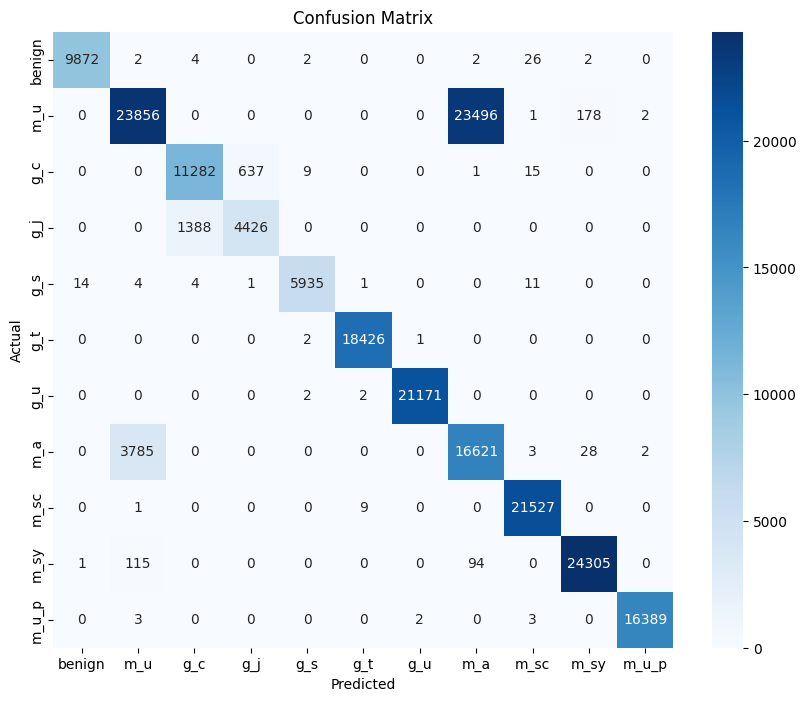

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      9910
         m_u       0.89      0.94      0.92     11944
         g_c       0.87      0.76      0.81      5814
         g_j       1.00      0.99      1.00      5970
         g_s       1.00      1.00      1.00     18429
         g_t       1.00      1.00      1.00     21175
         g_u       0.41      0.81      0.55     20439
         m_a       1.00      1.00      1.00     21537
        m_sc       0.99      0.99      0.99     24515
        m_sy       0.86      0.50      0.63     47533
       m_u_p       1.00      1.00      1.00     16397

    accuracy                           0.85    203663
   macro avg       0.91      0.91      0.90    203663
weighted avg       0.90      0.85      0.86    203663



In [ ]:
cm = confusion_matrix(actual_list, predicted_list, labels=list(autoencoders.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=autoencoders.keys(), yticklabels=autoencoders.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(actual_list, predicted_list, target_names=list(autoencoders.keys())))

In [ ]:
accuracy_score(actual_list, predicted_list)

0.8534196196658205

### Single Time Window

In [ ]:
times = ['L5', 'L3', 'L1', 'L0.1', 'L0.01']

Epoch 23: early stopping
Epoch 32: early stopping
Epoch 50: early stopping
Epoch 33: early stopping
513/513 [==============================] - 1s 2ms/step


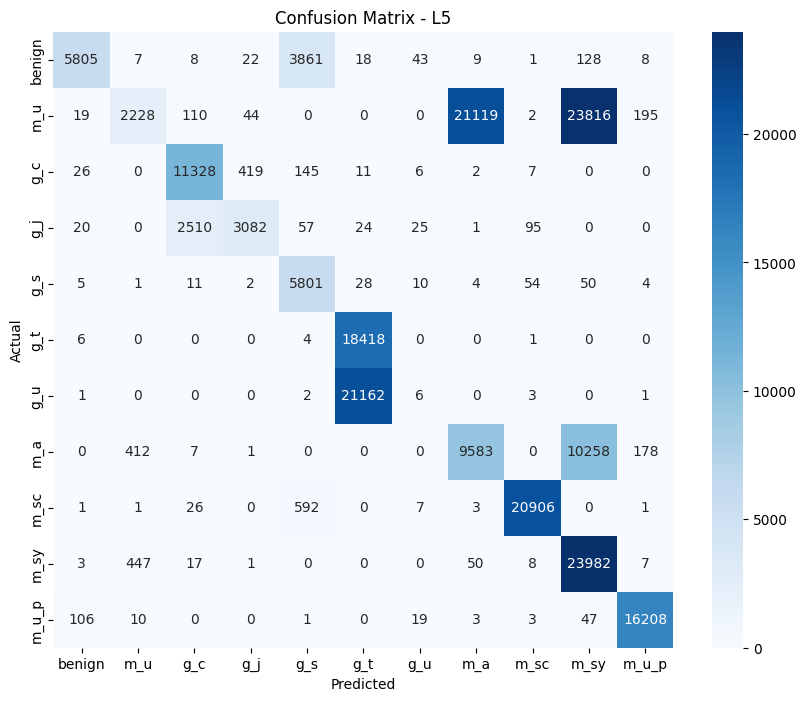

              precision    recall  f1-score   support

      benign       0.97      0.59      0.73      9910
         m_u       0.81      0.95      0.87     11944
         g_c       0.86      0.53      0.66      5814
         g_j       0.55      0.97      0.71      5970
         g_s       0.46      1.00      0.63     18429
         g_t       0.05      0.00      0.00     21175
         g_u       0.31      0.47      0.37     20439
         m_a       0.99      0.97      0.98     21537
        m_sc       0.41      0.98      0.58     24515
        m_sy       0.72      0.05      0.09     47533
       m_u_p       0.98      0.99      0.98     16397

    accuracy                           0.58    203663
   macro avg       0.65      0.68      0.60    203663
weighted avg       0.61      0.58      0.49    203663

Epoch 32: early stopping
Epoch 21: early stopping
Epoch 33: early stopping
Epoch 26: early stopping
513/513 [==============================] - 1s 1ms/step


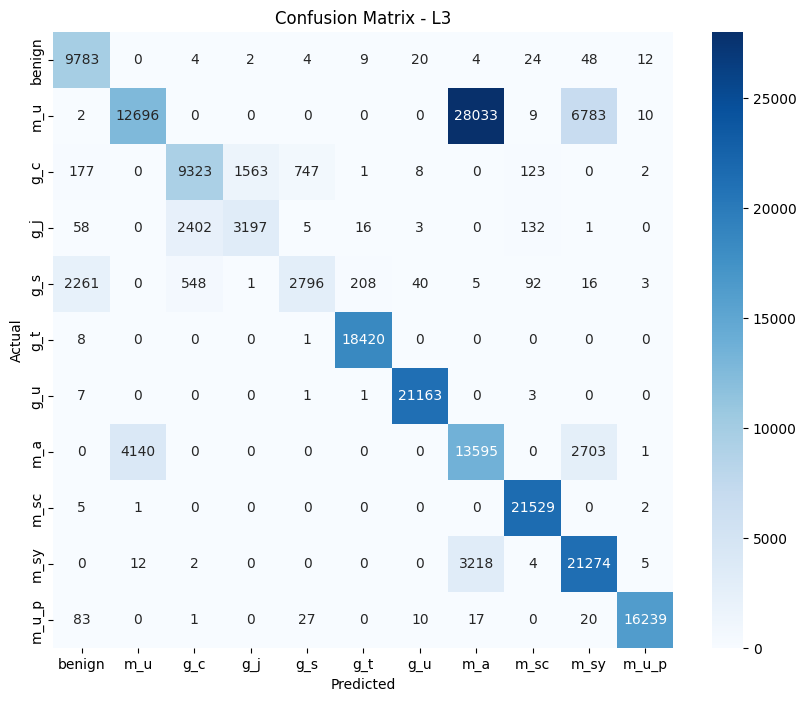

              precision    recall  f1-score   support

      benign       0.79      0.99      0.88      9910
         m_u       0.76      0.78      0.77     11944
         g_c       0.67      0.55      0.60      5814
         g_j       0.78      0.47      0.59      5970
         g_s       0.99      1.00      0.99     18429
         g_t       1.00      1.00      1.00     21175
         g_u       0.30      0.67      0.42     20439
         m_a       0.98      1.00      0.99     21537
        m_sc       0.69      0.87      0.77     24515
        m_sy       0.75      0.27      0.39     47533
       m_u_p       1.00      0.99      0.99     16397

    accuracy                           0.74    203663
   macro avg       0.79      0.78      0.76    203663
weighted avg       0.79      0.74      0.73    203663

Epoch 35: early stopping
Epoch 38: early stopping
Epoch 36: early stopping
Epoch 38: early stopping
Epoch 24: early stopping
Epoch 27: early stopping
513/513 [============================

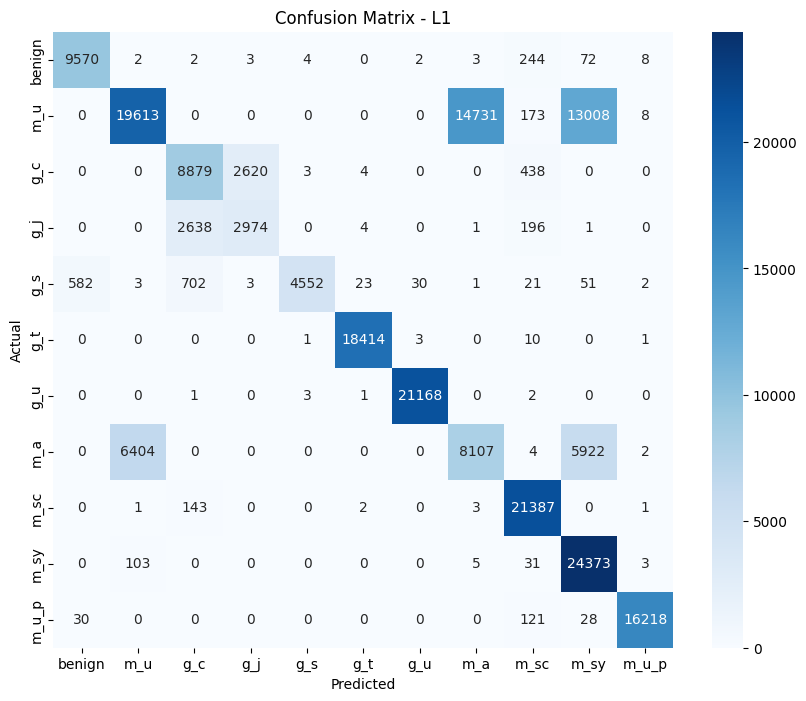

              precision    recall  f1-score   support

      benign       0.94      0.97      0.95      9910
         m_u       0.72      0.74      0.73     11944
         g_c       0.53      0.51      0.52      5814
         g_j       1.00      0.76      0.86      5970
         g_s       1.00      1.00      1.00     18429
         g_t       1.00      1.00      1.00     21175
         g_u       0.35      0.40      0.37     20439
         m_a       0.95      0.99      0.97     21537
        m_sc       0.56      0.99      0.72     24515
        m_sy       0.75      0.41      0.53     47533
       m_u_p       1.00      0.99      0.99     16397

    accuracy                           0.76    203663
   macro avg       0.80      0.80      0.79    203663
weighted avg       0.79      0.76      0.75    203663

Epoch 45: early stopping
Epoch 24: early stopping
Epoch 49: early stopping
Epoch 27: early stopping
Epoch 36: early stopping
Epoch 39: early stopping
513/513 [============================

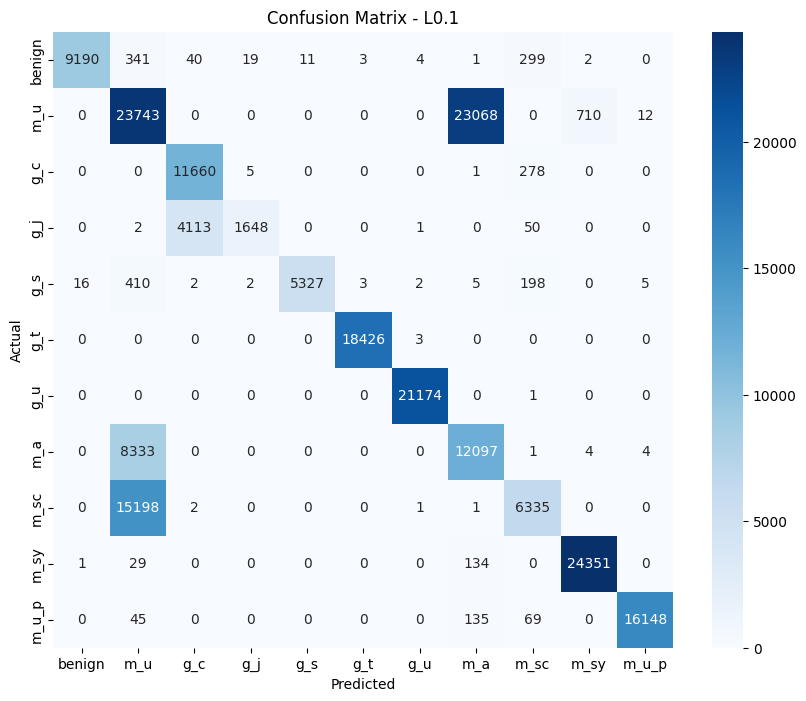

              precision    recall  f1-score   support

      benign       1.00      0.93      0.96      9910
         m_u       0.74      0.98      0.84     11944
         g_c       0.98      0.28      0.44      5814
         g_j       1.00      0.89      0.94      5970
         g_s       1.00      1.00      1.00     18429
         g_t       1.00      1.00      1.00     21175
         g_u       0.34      0.59      0.43     20439
         m_a       0.88      0.29      0.44     21537
        m_sc       0.97      0.99      0.98     24515
        m_sy       0.49      0.50      0.50     47533
       m_u_p       1.00      0.98      0.99     16397

    accuracy                           0.74    203663
   macro avg       0.85      0.77      0.78    203663
weighted avg       0.78      0.74      0.73    203663

Epoch 37: early stopping
Epoch 38: early stopping
Epoch 32: early stopping
Epoch 39: early stopping
513/513 [==============================] - 1s 2ms/step


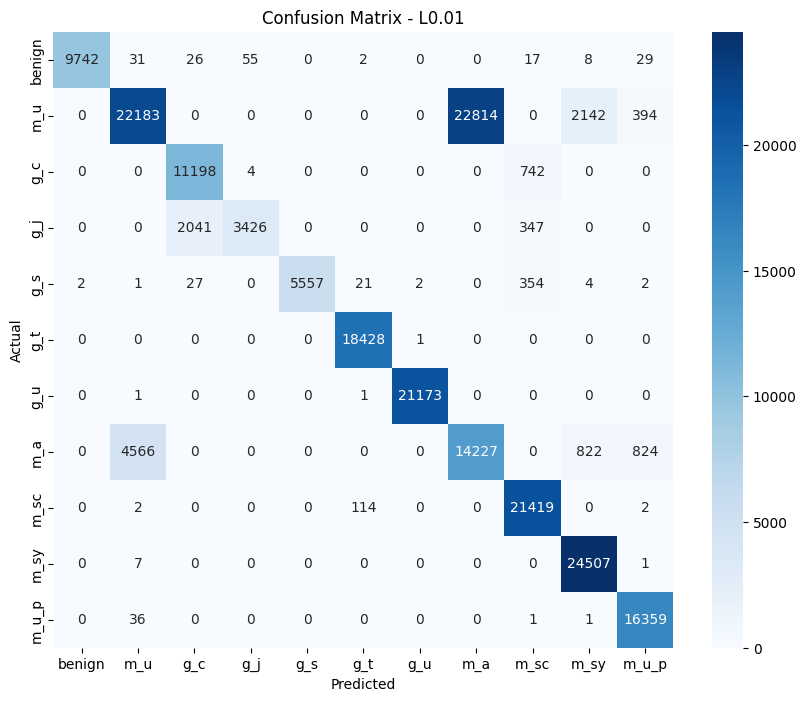

              precision    recall  f1-score   support

      benign       1.00      0.98      0.99      9910
         m_u       0.84      0.94      0.89     11944
         g_c       0.98      0.59      0.74      5814
         g_j       1.00      0.93      0.96      5970
         g_s       0.99      1.00      1.00     18429
         g_t       1.00      1.00      1.00     21175
         g_u       0.38      0.70      0.50     20439
         m_a       0.94      0.99      0.96     21537
        m_sc       0.89      1.00      0.94     24515
        m_sy       0.83      0.47      0.60     47533
       m_u_p       0.93      1.00      0.96     16397

    accuracy                           0.83    203663
   macro avg       0.89      0.87      0.87    203663
weighted avg       0.86      0.83      0.83    203663



In [ ]:
for time in times:
  X_train = {}
  X_test = {}

  for name, df in dfs.items():
    X_train[name], X_test[name] = train_test_split(df.loc[:, df.columns.str.contains(time)], test_size=0.2, random_state=42)

  autoencoders = {}

  for name, df in X_train.items():
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    scalers[name] = scaler

    autoencoder = build_autoencoder(df.shape[1], 5)

    log_dir = f"logs/fit/" + name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')

    autoencoder.fit(df, df, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[tensorboard_callback, early_stopping_callback])
    autoencoders[name] = autoencoder

  actual_vs_predict = {}

  for name, df in X_test.items():
    df = scalers[name].transform(df)
    reconstruction_errors = np.zeros((df.shape[0], len(autoencoders)))

    for i, (autoencoder_name, autoencoder) in enumerate(autoencoders.items()):
      reconstructed = autoencoder.predict(df)
      errors = np.mean(np.abs(df - reconstructed), axis=1)
      reconstruction_errors[:, i] = errors

    inverse_errors = np.max(reconstruction_errors) - reconstruction_errors

    probabilities = softmax(inverse_errors, axis=1)

    predicted_indices = np.argmax(probabilities, axis=1)
    predicted_autoencoders = [list(autoencoders.keys())[index] for index in predicted_indices]

    actual_vs_predict[name] = Counter(predicted_autoencoders)

  actual_list, predicted_list = [], []
  for actual_name, counter in actual_vs_predict.items():
      for predicted_name, count in counter.items():
          actual_list.extend([actual_name] * count)
          predicted_list.extend([predicted_name] * count)

  cm = confusion_matrix(actual_list, predicted_list, labels=list(autoencoders.keys()))
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=autoencoders.keys(), yticklabels=autoencoders.keys())
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(f'Confusion Matrix - {time}')
  plt.show()


  print(classification_report(actual_list, predicted_list, target_names=list(autoencoders.keys())))

  accuracy_score(actual_list, predicted_list)